## 迁移学习 训练bert  情感3分类训练

In [4]:
import pandas as pd 
import torch
import torch.nn as nn
from transformers import BertConfig, BertForSequenceClassification, BertTokenizer, AdamW
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, TensorDataset
import os
import pymysql

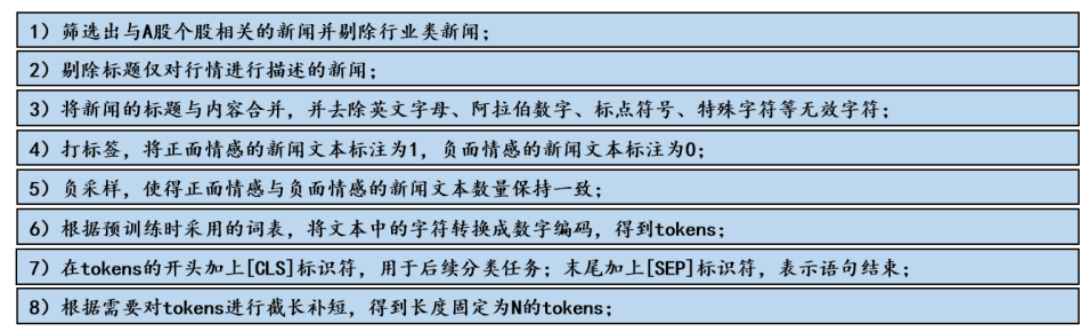

In [2]:
# df = pd.read_pickle('D:/redata/NLP_sen/news2017.pk')
df = pd.read_parquet('D:/redata/NLP_sen/chinascope_news.parquet')
df['title'] = df['title'].replace(r'[^\u4e00-\u9fa5]','',regex=True)
# df = df[df['news_emotion_indicator']!=0]
df['news_emotion_indicator'] = df['news_emotion_indicator']+1
df

,news_id,title,original_time,url,source,news_emotion_indicator,news_neutral_weight,news_positive_weight,news_negative_weight,company_relevance,company_emotion_indicator,company_neutral_weight,company_positive_weight,company_negative_weight
0,6834622,广发银行步入国寿时代小微贷款或压缩银政互动频繁,2017-01-03 02:21:00,http://finance.sina.com.cn/roll/2017-01-03/doc...,,1,0.0000,0.417000,0.583000,0.0261,0,0.9618,0.0352,0.0029
1,6834351,期货风险管理业务渐成特色,2017-01-03 07:51:00,http://www.hibor.com.cn/ecodetail_4758707.html,,2,0.0240,0.976000,0.000000,0.0166,0,0.4738,0.1876,0.3386
2,6836905,大易有塑为产业链上的端企业建立生态服务,2017-01-03 10:02:37,http://ec.china.com/eczcym/11176569/20170103/3...,,2,0.0325,0.967500,0.000000,0.0611,0,0.5042,0.4879,0.0079
3,6837482,国寿时代广发行小微贷款或压缩,2017-01-03 10:25:00,http://www.hibor.com.cn/ecodetail_4759278.html,,2,0.0000,0.914000,0.086000,0.0287,0,0.9618,0.0352,0.0029
4,6839126,平安银行提前发年终奖总行科室裁撤,2017-01-03 13:11:00,http://finance.sina.com.cn/chanjing/gsnews/201...,,2,0.0000,0.962981,0.037019,0.6135,1,0.3040,0.6823,0.0138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12115031,84716728,九号公司保障电动自行车安全就是助力行业长期可持续发展,2024-05-30 17:19:00,http://finance.ce.cn/stock/gsgdbd/202405/30/t2...,中国经济网,2,0.0084,0.990000,0.001600,0.7647,1,0.2125,0.7643,0.0232
12115032,84719738,九号公司积极履行社会责任推动行业智能化变革,2024-05-30 17:50:04,https://stock.stockstar.com/SS2024053000032662...,证券之星,2,0.0147,0.984000,0.001300,0.7941,1,0.1842,0.7924,0.0233
12115033,84721979,多方携手共筑电动车安全防线,2024-05-30 18:27:00,http://www.dzzq.com.cn/estate/47581750.html,大众证券网,2,0.0113,0.986400,0.002300,0.3333,1,0.1690,0.8230,0.0080
12115034,84731495,多方共探两轮电动车安全良方保障生命线这样做才对,2024-05-30 20:17:49,https://www.yangtse.com/zncontent/3794242.html,扬子晚报网,2,0.1460,0.768500,0.085500,0.3283,1,0.2040,0.7874,0.0086


In [3]:
# 确保正负感情的标签数量相同，确保样本没有bias
df_positive = df[df['news_emotion_indicator'] == 2]
df_neutral = df[df['news_emotion_indicator'] == 1]
df_negative = df[df['news_emotion_indicator'] == 0]
print(df_positive.shape)
print(df_neutral.shape)
print(df_negative.shape)

(6226012, 14)
(2931997, 14)
(2957027, 14)


In [4]:
# 假设 df 是你的原始 DataFrame
# 分离正负样本

# 确保正负样本数量相等，取数量较少的那部分
min_count = min(len(df_positive), len(df_neutral), len(df_negative))

# 随机抽样
df_positive_sampled = df_positive.sample(n=150000, random_state=42)
df_neutral_sampled = df_neutral.sample(n=150000, random_state=42)
df_negative_sampled = df_negative.sample(n=150000, random_state=42)

# 合并正负样本
df = pd.concat([df_positive_sampled, df_neutral_sampled, df_negative_sampled])

# 随机打乱顺序
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df

,news_id,title,original_time,url,source,news_emotion_indicator,news_neutral_weight,news_positive_weight,news_negative_weight,company_relevance,company_emotion_indicator,company_neutral_weight,company_positive_weight,company_negative_weight
0,10022332,午间公告一览利民股份实控人承诺个月内不减持,2018-01-24 12:53:00,http://www.hibor.com.cn/ecodetail_5491640.html,,1,0.447224,0.000000,0.552776,0.1250,0,0.9282,0.0248,0.0470
1,66864436,九典制药公司可转债项目正在有序推进中,2023-08-17 17:42:00,https://finance.eastmoney.com/a/20230817281597...,东方财富网,2,0.132200,0.865700,0.002100,0.7500,0,0.8130,0.1719,0.0152
2,83807019,唐山港最新公告拟转让全资子公司股权,2024-05-15 17:54:06,http://sc.stock.cnfol.com/gushiyaowen/20240515...,中金在线,1,0.668300,0.326200,0.005500,0.7500,0,0.9263,0.0704,0.0034
3,8772988,注意新三板投资的三大风险,2017-09-08 21:59:00,http://www.hibor.com.cn/ecodetail_5204117.html,,0,0.605000,0.394500,0.000500,0.0225,0,0.6974,0.3010,0.0016
4,19104243,国星光电公布业绩预告与国星半导体齐获项目补助金,2020-04-13 14:29:00,http://www.csia.net.cn/Article/ShowInfo.asp?In...,中国半导体行业协会,2,0.107000,0.893000,0.000000,0.8500,1,0.2383,0.7529,0.0089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449995,7059326,还能投资吗该怎么投看这一篇宝典就够了,2017-01-25 00:00:00,http://fund.stockstar.com/JC2017012600000492.s...,,1,0.000000,0.496748,0.503252,0.0104,0,0.8879,0.1017,0.0104
449996,9413319,月日午间公告一览罗平锌电遭深交所公开谴责,2018-09-12 12:47:00,"http://finance.eastmoney.com/news/1353,2018091...",,0,0.910000,0.090000,0.000000,0.3030,1,0.0248,0.9164,0.0588
449997,61316505,再相遇正泰绿能战队邀您共启能源科技,2023-05-12 14:26:05,https://news.solarbe.com/202305/12/367742.html,索比太阳能光伏网,2,0.019200,0.978600,0.002200,0.1181,0,0.8789,0.1202,0.0010
449998,65010020,天威视讯业绩快报上半年净利润万元同比增加,2023-07-19 18:10:29,http://stock.hexun.com/2023-07-19/209428803.html,和讯网,2,0.007700,0.988900,0.003400,0.6667,1,0.0147,0.9729,0.0124


In [5]:
# 判断是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 加载预训练的配置
# 加载分词器
config = BertConfig.from_pretrained('D:/redata/NLP_sen/finbert/bert_config.json')
tokenizer = BertTokenizer.from_pretrained('D:/redata/NLP_sen/finbert/vocab.txt')

Using device: cuda


C:\Users\sensen.t\Anaconda3\envs\nlp\lib\site-packages\transformers\tokenization_utils_base.py:2185: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(


In [6]:
# 准备数据
# 假设你的数据已经被处理成输入文本和标签的形式
input_texts = df['title']
labels = df['news_emotion_indicator'] # 对应的标签

input_ids = []
attention_masks = []

for text in input_texts:
    inputs = tokenizer.encode_plus( 
        text,
        add_special_tokens=True,
        max_length=256,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    input_ids.append(inputs['input_ids'])
    attention_masks.append(inputs['attention_mask'])

input_ids = torch.cat(input_ids, dim=0).to(device)
attention_masks = torch.cat(attention_masks, dim=0).to(device)
labels = torch.tensor(labels, dtype=torch.long).to(device)

In [7]:
print(tokenizer.decode(input_ids[-1]))

[CLS] 数 字 贸 易 重 塑 全 球 价 值 链 武 汉 力 量 为 中 国 经 济 发 展 注 入 新 动 能 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [8]:
input_ids[-1]

tensor([ 101, 3144, 2099, 6588, 3211, 7028, 1848, 1059, 4413,  817,  966, 7216,
        3636, 3727, 1213, 7030,  711,  704, 1744, 5307, 3845, 1355, 2245, 3800,
        1057, 3173, 1220, 5543,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

In [9]:
attention_masks[-1]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [10]:
labels[-1]

tensor(2, device='cuda:0')

In [11]:
#当要处理很久时存储中间数据
torch.save(input_ids, 'input_ids.pt')
torch.save(attention_masks, 'attention_masks.pt')
torch.save(labels, 'labels.pt')

In [12]:
input_ids = torch.load('input_ids.pt').to(device)
attention_masks = torch.load('attention_masks.pt').to(device)
labels = torch.load('labels.pt').to(device)

In [13]:
# 构建数据加载器
dataset = TensorDataset(input_ids, attention_masks, labels)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16)


In [14]:
# 加载预训练的模型并移到GPU上
model = BertForSequenceClassification.from_pretrained('D:/redata/NLP_sen/finbert/pytorch_model.bin', config=config)
model.to(device)

# 冻结预训练层
'''
for param in model.bert.parameters():
    param.requires_grad = False
'''

# 修改分类层为二分类
num_classes = 3
model.classifier = torch.nn.Linear(config.hidden_size, num_classes)
model.to(device)  # 将修改后的模型移回GPU


# 设置优化器和损失函数
optimizer = AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# 训练模型
i = 0
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        input_ids_batch, attention_masks_batch, labels_batch = batch
        input_ids_batch, attention_masks_batch, labels_batch = input_ids_batch.to(device), attention_masks_batch.to(device), labels_batch.to(device)
        
        outputs = model(input_ids_batch, attention_mask=attention_masks_batch)
        loss = loss_fn(outputs.logits, labels_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        i += 1
        if i % 100 == 0:
            print(f'当前epoch{epoch}，batch{i}，loss:{loss.item()}')
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in train_dataloader:
            input_ids_batch, attention_masks_batch, labels_batch = batch
            input_ids_batch, attention_masks_batch, labels_batch = input_ids_batch.to(device), attention_masks_batch.to(device), labels_batch.to(device)

            outputs = model(input_ids_batch, attention_mask=attention_masks_batch)
            _, predicted = torch.max(outputs.logits, dim=1)
            
            total += labels_batch.size(0)
            correct += (predicted == labels_batch).sum().item()

    train_accuracy = correct / total
    print(f'Epoch {epoch + 1}, Train Accuracy: {train_accuracy:.5f}')

# 在这之后可以添加评估代码和模型部署代码


C:\Users\sensen.t\Anaconda3\envs\nlp\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at D:/redata/NLP_sen/finbert/pytorch_model.bin and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sensen.t\Anaconda3\envs\nlp\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warni

当前epoch0，batch100，loss:0.7261221408843994
当前epoch0，batch200，loss:0.5648701786994934
当前epoch0，batch300，loss:0.8419281244277954
当前epoch0，batch400，loss:0.4152340590953827
当前epoch0，batch500，loss:0.7366493344306946
当前epoch0，batch600，loss:0.8715493679046631
当前epoch0，batch700，loss:0.7197969555854797
当前epoch0，batch800，loss:0.7024003863334656
当前epoch0，batch900，loss:0.5915609002113342
当前epoch0，batch1000，loss:0.5237447619438171
当前epoch0，batch1100，loss:0.47870397567749023
当前epoch0，batch1200，loss:0.8238449692726135
当前epoch0，batch1300，loss:0.48652997612953186
当前epoch0，batch1400，loss:0.5610389113426208
当前epoch0，batch1500，loss:0.6932540535926819
当前epoch0，batch1600，loss:0.1320207417011261
当前epoch0，batch1700，loss:0.5256806015968323
当前epoch0，batch1800，loss:0.5606222748756409
当前epoch0，batch1900，loss:0.2561846971511841
当前epoch0，batch2000，loss:0.2919922471046448
当前epoch0，batch2100，loss:0.3642098009586334
当前epoch0，batch2200，loss:0.2182898074388504
当前epoch0，batch2300，loss:1.017164707183838
当前epoch0，batch2400，

In [15]:
# 指定保存模型的文件夹路径
save_dir = 'D:/redata/NLP_sen/'

# 确保文件夹存在，如果不存在则创建
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 指定保存模型的文件路径
save_path = os.path.join(save_dir, '3classmodel500pt.pth')

# 保存模型
torch.save(model, save_path)

In [16]:
# 在所有 epoch 训练完成后计算测试集准确率
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in test_dataloader:
        print(total)
        input_ids_batch, attention_masks_batch, labels_batch = batch
        input_ids_batch, attention_masks_batch, labels_batch = input_ids_batch.to(device), attention_masks_batch.to(device), labels_batch.to(device)

        outputs = model(input_ids_batch, attention_mask=attention_masks_batch)
        _, predicted = torch.max(outputs.logits, dim=1)

        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.5f}')

0
16
32
48
64
80
96
112
128
144
160
176
192
208
224
240
256
272
288
304
320
336
352
368
384
400
416
432
448
464
480
496
512
528
544
560
576
592
608
624
640
656
672
688
704
720
736
752
768
784
800
816
832
848
864
880
896
912
928
944
960
976
992
1008
1024
1040
1056
1072
1088
1104
1120
1136
1152
1168
1184
1200
1216
1232
1248
1264
1280
1296
1312
1328
1344
1360
1376
1392
1408
1424
1440
1456
1472
1488
1504
1520
1536
1552
1568
1584
1600
1616
1632
1648
1664
1680
1696
1712
1728
1744
1760
1776
1792
1808
1824
1840
1856
1872
1888
1904
1920
1936
1952
1968
1984
2000
2016
2032
2048
2064
2080
2096
2112
2128
2144
2160
2176
2192
2208
2224
2240
2256
2272
2288
2304
2320
2336
2352
2368
2384
2400
2416
2432
2448
2464
2480
2496
2512
2528
2544
2560
2576
2592
2608
2624
2640
2656
2672
2688
2704
2720
2736
2752
2768
2784
2800
2816
2832
2848
2864
2880
2896
2912
2928
2944
2960
2976
2992
3008
3024
3040
3056
3072
3088
3104
3120
3136
3152
3168
3184
3200
3216
3232
3248
3264
3280
3296
3312
3328
3344
3360
3376
3392
3408
3